## Analizamos cómo el modelo representa aspectos de la distribución de una variable

En este tutorial vamos a explorar como es la distribución de probabilidades en el modelo para un dominio reducido:

- Vamos a tomar el mismo set de datos que descargamos
- Vamos a calcular el promedio semanal
- Vamos a calcular la función de distribución de probabilidad y la función de distribución de probabilidad acumulada


In [1]:
# Partimos importando los modulos a utilizar:
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import xarray as xr
import s3fs
%matplotlib inline

from scipy.stats import norm
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt


Primero definimos algunas funciones que vamos a usar

In [2]:
# funcion para acomodar xarrays antes de concatenarlos
def preprocess_ds(ds):
    ds['S'] = ds.time.values[0]
    ds['time'] = ds.time.values - ds.time.values[0]
    ds = ds.rename({'time': 'leadtime'})
    return ds
    
# funcion para calcular la CDF de los datos
def calcular_cdf(datos):
    n = len(datos)
    x_ordenados = np.sort(datos)
    cdf = np.arange(1, n + 1) / n
    return x_ordenados, cdf

Vamos a estudiar este comportamiento con el mismo set de variables que ya trabajamos

In [3]:
variable = 'tmean'
lat_n = -20
lat_s = -30
lon_w = -65
lon_e = -55
ref_date = datetime.datetime.strptime('20101201', "%Y%m%d")

Abrimos los datos corregidos y sin corregir seleccionamos la semana 2 de pronostico. Hacemos los propio con las observaciones. Aplicamos el promedio semanal

In [4]:
# funcion para acomodar xarrays antes de concatenarlos
def preprocess_ds(ds, variable=variable):
    ds = ds.assign_coords(S=ds.time.values[0], M=int(ds[variable].encoding['source'][-6:-4]))
    ds['time'] = ds.time.values - ds.time.values[0]
    ds = ds.rename({'time': 'leadtime'})
    return ds

# funcion para calcular la CDF de los datos
def calcular_cdf(datos):
    n = len(datos)
    x_ordenados = np.sort(datos)
    cdf = np.arange(1, n + 1) / n
    return x_ordenados, cdf

# función para obtener el segundo dato de cada grupo
def get_second_data(group):
    return group.isel(S=1)

Vamos a tomar de la base de datos de sissa los datos corregidos. Vamos a ver como se programa para seleccionar todas las fechas alrededor del 2 de mayo de cada año del período 2010-2019.

In [6]:
# DATOS CORREGIDOS
fs = s3fs.S3FileSystem(anon=True)
BUCKET_NAME = 'sissa-forecast-database'
tforecast = 'subseasonal'
modelo = 'GEFSv12_corr'
list_df = []
for i in np.arange(2010, 2020, 1): #loop sobre años
    loop_date = ref_date.replace(year=i) - timedelta(days=15) # reemplazo el año y arranco 15 días antes de la fecha
    while loop_date < (ref_date.replace(year=i) + timedelta(days=15)): # el loop es hasta 15 días despues
        if loop_date.weekday() == 2: # los pronos están disponibles los miercoles
            PATH = tforecast + '/' + modelo + '/' + variable + '/' + loop_date.strftime('%Y') + '/' + loop_date.strftime('%Y%m%d') + '/'            
            # Listamos todos los archivos dentro del bucket + PATH
            remote_files = fs.glob('s3://' + BUCKET_NAME + '/' + PATH + '*.nc')
            # Iterate through remote_files to create a fileset
            fileset = [fs.open(file) for file in remote_files]
            # This works
            data = xr.open_mfdataset(fileset, combine='nested', concat_dim='M', preprocess=preprocess_ds)
            data = data.sel(lat=slice(lat_n, lat_s), lon=slice(lon_w, lon_e),
                            leadtime=slice(np.timedelta64(8, 'D'), np.timedelta64(14, 'D'))).mean('leadtime', skipna=True)
            list_df.append(data)
            
        loop_date += timedelta(days=1)

ds_corr = xr.concat(list_df, dim='S')
print(ds_corr)

<xarray.Dataset>
Dimensions:   (S: 43, M: 11, lat: 41, bounds2: 2, lon: 41)
Coordinates:
  * lat       (lat) float64 -20.0 -20.25 -20.5 -20.75 ... -29.5 -29.75 -30.0
  * lon       (lon) float64 -65.0 -64.75 -64.5 -64.25 ... -55.5 -55.25 -55.0
  * S         (S) datetime64[ns] 2010-11-17 2010-11-24 ... 2019-12-04 2019-12-11
  * M         (M) int64 0 1 2 3 4 5 6 7 8 9 10
Dimensions without coordinates: bounds2
Data variables:
    lat_bnds  (S, M, lat, bounds2) float64 dask.array<chunksize=(1, 1, 41, 2), meta=np.ndarray>
    lon_bnds  (S, M, lon, bounds2) float64 dask.array<chunksize=(1, 1, 41, 2), meta=np.ndarray>
    tmean     (S, M, lat, lon) float64 dask.array<chunksize=(1, 1, 41, 41), meta=np.ndarray>


Repetimos para los datos sin corregir

In [7]:
# DATOS SIN CORREGIR
fs = s3fs.S3FileSystem(anon=True)
BUCKET_NAME = 'sissa-forecast-database'
tforecast = 'subseasonal'
modelo = 'GEFSv12'
list_df = []
for i in np.arange(2010, 2020, 1): #loop sobre años
    loop_date = ref_date.replace(year=i) - timedelta(days=15) # reemplazo el año y arranco 15 días antes de la fecha
    while loop_date < (ref_date.replace(year=i) + timedelta(days=15)): # el loop es hasta 15 días despues
        if loop_date.weekday() == 2: # los pronos están disponibles los miercoles
            PATH = tforecast + '/' + modelo + '/' + variable + '/' + loop_date.strftime('%Y') + '/' + loop_date.strftime('%Y%m%d') + '/'            
            # Listamos todos los archivos dentro del bucket + PATH
            remote_files = fs.glob('s3://' + BUCKET_NAME + '/' + PATH + '*.nc')
            # Iterate through remote_files to create a fileset
            fileset = [fs.open(file) for file in remote_files]
            # This works
            data = xr.open_mfdataset(fileset, combine='nested', concat_dim='M', preprocess=preprocess_ds)
            data = data.sel(lat=slice(lat_n, lat_s), lon=slice(lon_w, lon_e),
                            leadtime=slice(np.timedelta64(8, 'D'), np.timedelta64(14, 'D'))).mean('leadtime', skipna=True)
            list_df.append(data)
            
        loop_date += timedelta(days=1)

ds_uncal = xr.concat(list_df, dim='S')

Abrimos los datos observados y selecciono la segunda semana a patir de los miercoles alrededor de la fecha de interes para los años de estudio

In [9]:
# Obtenemos los datos de ERA5
fs = s3fs.S3FileSystem(anon=True)
BUCKET_NAME = 'sissa-forecast-database'
tforecast = 'ERA5'
modelo = 'ERA5'
list_df = []
PATH = tforecast + '/' + variable 
remote_files = fs.glob('s3://' + BUCKET_NAME + '/' + PATH + '/' + '*.nc')
# Iterate through remote_files to create a fileset
fileset = [fs.open(file) for file in remote_files]
data = xr.open_mfdataset(fileset, combine='nested', concat_dim='time')
data = data.sel(latitude=slice(lat_n, lat_s), longitude=slice(lon_w, lon_e))

for i in np.arange(2010, 2020, 1):
    loop_date = ref_date.replace(year=i) - timedelta(days=15)
    while loop_date < (ref_date.replace(year=i) + timedelta(days=15)):
        if loop_date.weekday() == 2:
            era = data.sel(time= slice(loop_date + timedelta(days=8), loop_date + timedelta(days=14))).mean('time')
            era['S'] = loop_date
            list_df.append(era)
        
        loop_date += timedelta(days=1)
ds_era = xr.concat(list_df, dim='S')
ds_era = ds_era.compute()

Tomamos los datos y los ajustamos a una distribución normal

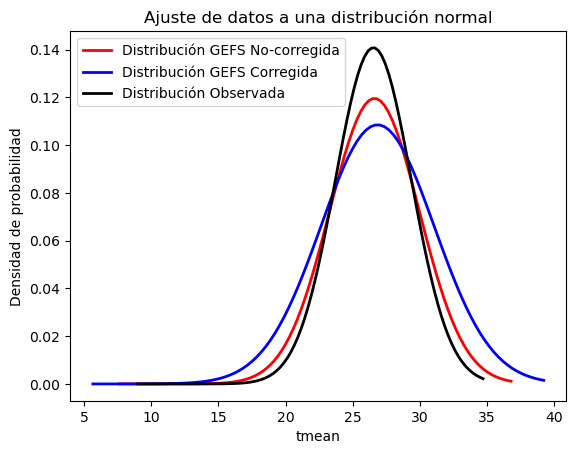

In [10]:
# Ajuste de los datos a una distribución normal
aux =ds_uncal[variable].values.flat
aux_cor =ds_corr[variable].values.flat
aux_era = ds_era[variable].values.flat[~np.isnan(ds_era[variable].values.flat)] 

media_estimada = np.mean(aux)
desviacion_estimada = np.std(aux)
media_estimada_cor = np.mean(aux_cor)
desviacion_estimada_cor = np.std(aux_cor)
media_estimada_era = np.nanmean(aux_era)
desviacion_estimada_era = np.nanstd(aux_era)

x = np.linspace(np.min(aux), np.max(aux), 100)
y = norm.pdf(x, media_estimada, desviacion_estimada)
plt.plot(x, y, 'r-', lw=2, label='Distribución GEFS No-corregida')

x_cor = np.linspace(np.min(aux_cor), np.max(aux_cor), 100)
y_cor = norm.pdf(x, media_estimada_cor, desviacion_estimada_cor)
plt.plot(x_cor, y_cor, 'b-', lw=2, label='Distribución GEFS Corregida')

x_era = np.linspace(np.min(aux_era), np.max(aux_era), 100)
y_era = norm.pdf(x_era, media_estimada_era, desviacion_estimada_era)
plt.plot(x_era, y_era, 'k-', lw=2, label='Distribución Observada')

plt.xlabel(variable)
plt.ylabel('Densidad de probabilidad')
plt.title('Ajuste de datos a una distribución normal')
plt.legend()
plt.show()

Repetimos pero ahora graficamos la función de distribucion acumulada

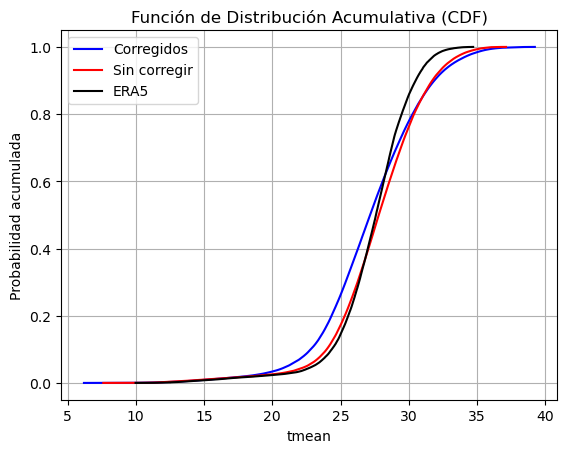

In [9]:
x_ordenados1, cdf1 = calcular_cdf(aux_cor)
x_ordenados2, cdf2 = calcular_cdf(aux)
x_ordenados3, cdf3 = calcular_cdf(aux_era)

# Plotear la CDF
plt.plot(x_ordenados1, cdf1, 'b', label='Corregidos')
plt.plot(x_ordenados2, cdf2, 'r', label='Sin corregir')
plt.plot(x_ordenados3, cdf3, 'k', label='ERA5')
plt.xlabel(variable)
plt.ylabel('Probabilidad acumulada')
plt.title('Función de Distribución Acumulativa (CDF)')
plt.legend()
plt.grid(True)
plt.show()